In [193]:

import rasterio
import rasterio.features
import rasterio.warp
from rasterio.enums import Resampling
from rasterio import Affine, MemoryFile

from matplotlib import pyplot
import geopandas
from geopandas import GeoDataFrame, GeoSeries
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns
from shapely.geometry import Point, Polygon
import numpy as np
from datetime import datetime
import json

plt.rcParams["figure.figsize"] = [8,6]

In [194]:
# load tiff file and create ndarray
# file_name = "forest_raw_data/Hansen_GFC-2020-v1.8_treecover2000_40N_130W.tif"
# file_name = "forest_raw_data/Hansen_GFC-2020-v1.8_gain_40N_130W.tif"
file_name = "forest_raw_data/Hansen_GFC-2020-v1.8_datamask_50N_130W.tif"
# file_name = "forest_raw_data/Hansen_GFC-2020-v1.8_lossyear_40N_130W.tif"
# img = rasterio.open(file_name)
# tiff_array = img.read(1)

upscale_factor = 1./10
dataset = rasterio.open(file_name)

In [195]:
from pyproj import Transformer
transformer = Transformer.from_crs("EPSG:4326", dataset.crs, always_xy=True)

In [196]:
%matplotlib agg
%matplotlib agg

# Comments/explanations for this code in other notebooks.
boundy1, boundx1 = 32.5239920572277, -124.38498819727948
boundy2, boundx2 = 42.01477274871176, -114.13276715586254

plt.gca().set_xlim([boundx1, boundx2])
plt.gca().set_ylim([boundy1, boundy2])

xmin, xmax, ymin, ymax = boundx1, boundx2, boundy1, boundy2

granularity = 400
xx, yy = np.meshgrid(np.linspace(xmin,xmax,granularity), np.linspace(ymin,ymax, int(granularity/abs(xmax - xmin) * abs(ymax - ymin))))

yurok_reservation_long = -123.891719
yurok_reservation_lat = 41.372322

travis_long = -121.939857
travis_lat = 38.272118

region_indcs = np.where(np.logical_and(np.logical_and(xx >= yurok_reservation_long, xx <= travis_long), np.logical_and(yy >= travis_lat, yy <= yurok_reservation_lat)))

xc = xx[region_indcs]
yc = yy[region_indcs]

# The data is separated out in huge chunks, and our grid of points lies in more than one chunk.
# We need to retrieve data across separate tiff images consequently.

quad_50N_args = np.where(np.logical_and(np.logical_and(-130 <= xc, xc <= -120), np.logical_and(40 <= yc, yc <= 50)))[0]
quad_40N_args = np.where(np.logical_and(np.logical_and(-130 <= xc, xc <= -120), np.logical_and(30 <= yc, yc < 40)))[0]
xc_quad_50N, yc_quad_50N = xc[quad_50N_args], yc[quad_50N_args]
xc_quad_40N, yc_quad_40N = xc[quad_40N_args], yc[quad_40N_args]

# This transformation is not needed actually, the data is in a modern representation
# longs, lats = transformer.transform(xc_quad_50N, yc_quad_50N)
longs, lats = xc_quad_50N, yc_quad_50N

In [197]:
# The whole point of the next two notebook cells is to use a scaled down TIFF image. The original is huge (40,000^2).
# Rasterio's read function, while it works nicely, returns only a numpy array instead of a rasterio DatasetReader object,
# and we lose all information about the rasterio tiff representation originally (e.g. coordinate system, sampling abilities, etc.)
# Rasterio does not have a nice method to easily obtain a DataReader representation that is scaled up/down from the original TIFF.
# So to loop around this we rewrite the scaled down data in memory and open it as a DataReader object and work with that.

# Credit to https://gis.stackexchange.com/questions/329434/creating-an-in-memory-rasterio-dataset-from-numpy-array

from contextlib import contextmanager
@contextmanager
def resample_raster(raster, scale=1./10):
    t = raster.transform

    # rescale the metadata
    ## Adjust transformation so dims are integers, not floats.
    transform = Affine(t.a / scale, t.b, t.c, t.d, t.e / scale, t.f)
    height = int(raster.height * scale)
    width = int(raster.width * scale)

    profile = raster.profile
    profile.update(transform=transform, driver='GTiff', height=height, width=width)

    ## There were a decent amount of 0s, 100s in the original canopy cover image
    ## -> using bilinear resampling here to do some small smoothing (2x2 window average)
    ## Can also experiment with cubic smoothing as well later (4x4 window average)
    ## For discrete categories, we use nearest neighbor.

    data = raster.read( # Note changed order of indexes, arrays are band, row, col order not row, col, band
            out_shape=(raster.count, height, width),
            resampling=Resampling.nearest,
        )

    with MemoryFile() as memfile:
        with memfile.open(**profile) as new_data: # Open as DatasetWriter
            new_data.write(data)
            del data

        with memfile.open() as new_data:  # Reopen as DatasetReader
            yield new_data  # Note yield not return

Orig dims: (40000, 40000), New dims: (4000, 4000)


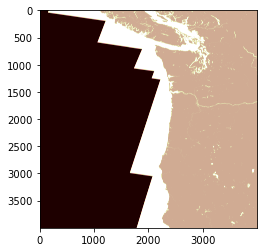

In [198]:
%matplotlib inline
vals = None

with rasterio.open(file_name) as src:
    with resample_raster(src) as dataset:
        print('Orig dims: {}, New dims: {}'.format(src.shape, dataset.shape))

        pyplot.imshow(dataset.read(1), cmap='pink')
        pyplot.show()
        vals = np.array(list(dataset.sample(zip(longs, lats), masked=True))).flatten()


In [199]:
print(vals)

[1 1 1 ... 1 1 1]


In [200]:
print(np.min(vals))
print(np.max(vals))
print(len(vals))

1
2
4104


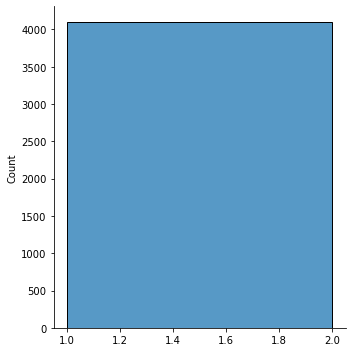

In [201]:
%matplotlib inline
sns.displot(vals, binwidth=1)
plt.show()

In [202]:
print(len(np.where(vals == 0)[0]))
print(len(np.where(vals == 1)[0]))
print(len(np.where(vals == 2)[0]))
print(len(longs))

0
4088
16
4104


In [203]:
# Rewrite into np array and save.
datapoints = np.array([longs, lats, vals]).astype(np.double).T

In [204]:
output_file="../data/datamask_50.npy"

In [205]:
# Verify shape and preview values
print(longs.shape)
print(datapoints.shape)
print(datapoints[:5, :])

(4104,)
(4104, 3)
[[-123.87109241   40.00859146    1.        ]
 [-123.84539762   40.00859146    1.        ]
 [-123.81970283   40.00859146    1.        ]
 [-123.79400804   40.00859146    1.        ]
 [-123.76831325   40.00859146    1.        ]]


In [206]:
# Save
np.save(output_file, datapoints)